In [3]:
import numpy as np
import numpy.random as npr
import scipy
import scipy.linalg as la
from scipy import stats
import torch
from torch import nn
import torch.utils.data as Data
from torch.autograd import Variable
import signatory

# functionality for plots:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# nonlinear ICA
import SigIC as sigic
import SigIC_ANN as sigNN
import MonomialDiscordance as mondis

import itertools
from itertools import permutations
from itertools import groupby
import time
import os
import pickle

# linear ICA
from sklearn.decomposition import FastICA

# simulate fractional Brwonion motion
from fbm import FBM

# Generate the Source
We will generate two kinds of IC sources:
* Geometric Brownian motion ($\gamma$-cotranstive) in $\mathbb R^2$.
* fractional Brownian motion ($\gamma$-cotranstive) in $\mathbb R^2$.

In [4]:
# simultae GBM
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims): 

    # Read parameters
    S0 = s0         # initial spot level
    r = mu          # mu = rf in risk neutral framework 
    T = horizon     # time horizion
    t = timesteps   # number of time steps
    n = n_sims      # number of simulation
    
    # Define dt
    dt = T/t        # length of time interval  
    
    # Simulating 'n' asset price paths with 't' timesteps
    S = np.zeros((t, n))
    S[0] = S0

    for i in range(0, t-1):
        phi = npr.standard_normal(n)                                                   # psuedo random numbers
        #S[i+1] = S[i] * (1 + r * dt + sigma * sqrt(dt) * phi)                            # vectorized operation per timesteps
        S[i+1] = S[i] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * phi)         # alternate form
       # print(S)
        
    return S

#set parameters
mu1=0.5
mu2=0
sigma1=1
sigma2=0.5
T=1
n=500000

npr.seed(1)
gbm1=simulate_path(1000,mu1,sigma1,T,n,1)
gbm1=1/(np.max(np.abs(gbm1)))*gbm1
npr.seed(22)
gbm2=simulate_path(3000,mu2,sigma2,T,n,1)
gbm2=1/(np.max(np.abs(gbm2)))*gbm2

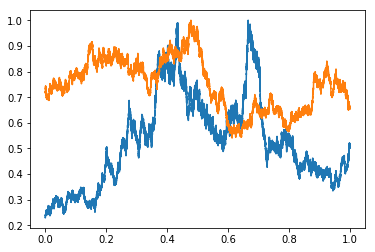

In [5]:
# plot the gbm realisation
plt.plot(np.linspace(0, T, n), gbm1)
plt.plot(np.linspace(0, T, n), gbm2)

In [6]:
# simulate fractional Brownian motion
# Set parameters
n2 = 500000-1  # Number of data points
H1 = 0.2
H2 = 0.3 # Hurst exponent
H3=0.4
H4=0.35
T = 1.0   # Total time

# Create fBm object
np.random.seed(66)
f1 = FBM(n=n2, hurst=H1, length=T)
f2 = FBM(n=n2, hurst=H2, length=T)
f3 = FBM(n=n2, hurst=H3, length=T)
f4 = FBM(n=n2, hurst=H4, length=T)

# Generate fBm realization
fbm1 = f1.fbm()
fbm1 = 1/(np.max(np.abs(fbm1)))*fbm1
fbm2 = f2.fbm()
fbm2 = 1/(np.max(np.abs(fbm2)))*fbm2
fbm3 = f3.fbm()
fbm3 = 1/(np.max(np.abs(fbm3)))*fbm3
fbm4 = f4.fbm()
fbm4 = 1/(np.max(np.abs(fbm4)))*fbm4

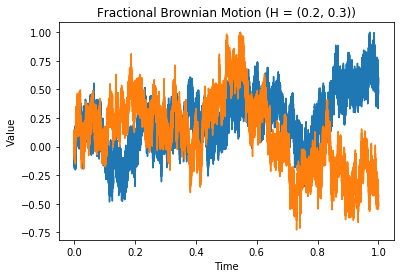

In [7]:
# Plot the fBm realization
plt.plot(np.linspace(0, T, n), fbm1)
plt.plot(np.linspace(0, T, n), fbm2)
plt.title(f'Fractional Brownian Motion (H = {H1,H2})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

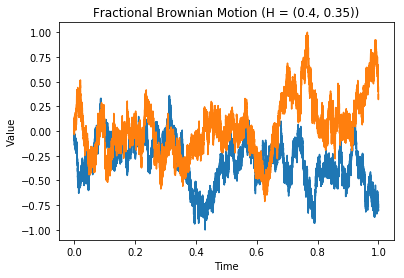

In [8]:
# Plot the fBm realization
plt.plot(np.linspace(0, T, n), fbm3)
plt.plot(np.linspace(0, T, n), fbm4)
plt.title(f'Fractional Brownian Motion (H = {H3,H4})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Text(0.5, 1.0, 'FBM processes for Source in $R^4$')

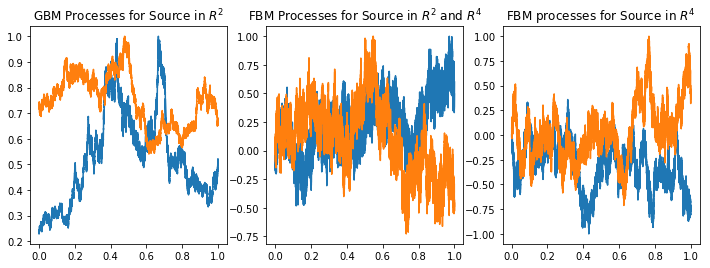

In [605]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot data on each subplot
# plot the gbm realisation
ax1.plot(np.linspace(0, T, n), gbm1)
ax1.plot(np.linspace(0, T, n), gbm2)
ax1.set_title('GBM Processes for Source in $R^2$')

ax2.plot(np.linspace(0, T, n), fbm1)
ax2.plot(np.linspace(0, T, n), fbm2)
ax2.set_title('FBM Processes for Source in $R^2$ and $R^4$')

ax3.plot(np.linspace(0, T, n), fbm3)
ax3.plot(np.linspace(0, T, n), fbm4)
ax3.set_title('FBM processes for Source in $R^4$')

Combine the source components

In [9]:
# source
S_gbm=np.hstack((gbm1,gbm2))
S_fbm=np.vstack((fbm1,fbm2)).transpose() # so that both have dimension (500000,2)
S_4d=np.vstack((fbm1, fbm2,fbm3,fbm4)).transpose()[200000:400000] # have shape (200000,4)
np.shape(S_4d)

(200000, 4)

# Nonlinear Transformation


nonlinear invertible transformation function $f_1:R^2\rightarrow R^2$:
$$f_1=h_{(0,0.5)}\circ A\circ h^{-1}_{(0,1)}\quad for \quad A=\begin{bmatrix} 0.77298565 & 0.63442351 \\ 0.63442351 &-0.77298565 \end{bmatrix} $$
$$and \quad h_\theta(x_1,x_2)= \left(\begin{array}{c} p_{\theta_1}(x_1)+x_2 \\ -\theta_2\cdot x_1 \end{array}\right) \quad \quad h^{-1}_\theta(x_1,x_2)= \left(\begin{array}{c} -x_2/\theta_2 \\ x_1-p_{\theta_1}(-x_2/\theta_2) \end{array}\right)$$
where $p_{\theta_1}(x)=x^3+\theta_1$. 
This function is also known as Henon map. 

The nonlinear invertible function $f_2:R^4\rightarrow R^4$ is randomly generate from neural network.

In [10]:
'''Hénon Map and its Inverse:'''

# h_theta:
def HenonX3(x, theta):
    # i-th column of x is i-th coordinate (x_i)
    
    y      = np.zeros(np.shape(x))
    y[:,0] = x[:,0]**3 + theta[0] + x[:,1] # = f_1(x,y)
    y[:,1] = -theta[1]*x[:,0]              # = f_2(x,y)
    
    return y

# (h_theta)^{-1}:
def HenonX3Inv(x, theta):
    
    y      = np.zeros(np.shape(x))
    y[:,0] = -x[:,1]/theta[1]                         # = (f^{-1})_1(x,y)
    y[:,1] = x[:,0] - (-x[:,1]/theta[1])**3 - theta[0] # = (f^{-1})_2(x,y)
    
    return y

'''f_1:'''

# A:
A = np.asarray([[ 0.77298565,  0.63442351],
                [ 0.63442351, -0.77298565]])

def LinTrafo(B,x):
# input: dxd-matrix A (as (d,d)-array) and list x of argument vectors (rows) (as (n,d)-array)
# return: (A@vj)_j (--> (n,d)-array), where vj is the jth row of x
    y      = np.zeros(np.shape(x))
    z      = (B@(x.T)).T
    y[:,0] = z[:,0]
    y[:,1] = z[:,1]
    
    return y

# f_1:
def f_1(x):
# input: (n,d)-array x, where x=(x1,x2) (i.e., i-th column of x is i-th coordinate x_i)
# returns: f_1(x) (as (n,d)-array)
    return HenonX3(LinTrafo(A,HenonX3Inv(x, np.asarray([0,1]))), np.asarray([0,0.5]))

def inv_aux(x,B,theta):
    
    y1 = HenonX3Inv(x, np.asarray([0,theta[1]]))
    y2 = LinTrafo(B.T,y1)
    y3 = HenonX3(y2, np.asarray([0,theta[0]]))
    
    return y3


In [139]:
'''Nonlinear Mixing Transformations to Reverse via Neural Networks:'''

# Mixing A, f : \R^2 --> \R^2:
M1 = np.asarray([[0.94211376, 0.14512117],[0.42407973, 0.78168134]])
def NNmixA(x):
    y = inv_aux(f_1(1.1*x), M1, np.asarray([1,-0.35]))
    return LinTrafo(M1,y) 

# Mixing B, f : \R^4 --> \R^4: this mixing is defined by an invertible ANN on \R^4.

# define Mixing Model:
class mix_model(nn.Module): # 4-layer mixing, 4-dim input
    def __init__(self, d):
        h = d # d = n_in = n_out; l = 4 (number of layers; ~'degree of nonlinearity')
        # number of inputs/outputs [n_in/n_out], number of neurons in hidden layers [hi]
        super(mix_model, self).__init__() 
        self.l1 = nn.Linear(d, h)
        self.l2 = nn.Linear(h, h)
        self.l3 = nn.Linear(h, h)
        self.l4 = nn.Linear(h, d)
    
    # Forward Propagation:
    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = torch.tanh(self.l3(x))
        x = torch.tanh(self.l4(x))
        return x
    
# instantiate mixing model:
torch.manual_seed(0) 
NNmixB = mix_model(4)
NNmixB.float()

mix_model(
  (l1): Linear(in_features=4, out_features=4, bias=True)
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (l3): Linear(in_features=4, out_features=4, bias=True)
  (l4): Linear(in_features=4, out_features=4, bias=True)
)

In [140]:
print('Mixing Map B Invertible?')
a = torch.det(NNmixB.l1.weight)*torch.det(NNmixB.l2.weight)*torch.det(NNmixB.l3.weight)*torch.det(NNmixB.l4.weight).item()
print('-->', (torch.abs(a)>1e-9).item())

Mixing Map B Invertible?
--> True


Obtain $X=f(S)$ with function $f_1,f_2$ above

In [389]:
'''Observables X = f(S)'''
X_gbm = torch.from_numpy(NNmixA(S_gbm)).float() #require torch tensors for python-based ANN-functionality
X_fbm = torch.from_numpy(NNmixA(S_fbm)).float()

X_4d   = NNmixB(torch.from_numpy(S_4d).float()).float()

X_gbm = sigic.rescale(X_gbm)
X_fbm = sigic.rescale(X_fbm)

To see whether the concordance matrices of X and S and permutation matrices are similar, so that the mixing transformations are not trivial

In [390]:
Concordgbm = mondis.ConcordanceMatrix(X_gbm.numpy(),S_gbm,100,1,'kendall')
Concordfbm = mondis.ConcordanceMatrix(X_fbm.numpy(),S_fbm,100,1,'kendall')
Concord4d   = mondis.ConcordanceMatrix(X_4d.detach().numpy(),S_4d,100,1,'kendall')
print("Concordance of X_gbm and S_gbm:\n",Concordgbm)
print("")
print("Concordance of X_fbm and S_fbm:\n",Concordfbm)
print("")
print("Concordance of X_4d and S_4d:\n",Concord4d)

Concordance of X_gbm and S_gbm:
 [[0.45121873 0.52442894]
 [0.02082948 0.7065143 ]]

Concordance of X_fbm and S_fbm:
 [[0.12983583 0.69416393]
 [0.48707496 0.65757864]]

Concordance of X_4d and S_4d:
 [[0.67469641 0.37763542 0.5520078  0.25956251]
 [0.69404327 0.42747987 0.49968609 0.3099724 ]
 [0.56834276 0.44566043 0.52530928 0.14639848]
 [0.27188033 0.79991537 0.10803401 0.34912277]]


Set up neural network for training

In [388]:
'''Feedforward-Models for Demixing-ANNs (14)'''

class demixA(nn.Module):
    def __init__(self, n_in, h1, h2, h3, n_out):
        # number of inputs/outputs [n_in/n_out], number of neurons in hidden layers [hi]
        super(demixA, self).__init__() 
        self.l1 = nn.Linear(n_in, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, h3)
        self.l4 = nn.Linear(h3, n_out)
    
    # Forward Propagation:
    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = torch.tanh(self.l3(x))
        x = torch.tanh(self.l4(x))
        return x
    
class demixB(nn.Module): # Single-Layer NN
    def __init__(self, n_in, h1, n_out):
        # number of inputs/outputs [n_in/n_out], number of neurons in hidden layers [hi]
        super(demixB, self).__init__() 
        self.l1 = nn.Linear(n_in, h1)
        self.l2 = nn.Linear(h1, n_out)
    
    # Forward Propagation:
    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = nn.LeakyReLU(0.5)(self.l2(x))
        return x

define the loss function (contrast function)

In [16]:
'''Specification of (15) (loss function)'''

'''Mixing A:'''
dA  = 2                # mixing-dimension
mA  = 6                # orders for control-tuple
muA = np.asarray([mA]) # control-tuple
blA = 50                # batchlength

# coefficient matrices (see \hl{Sigtorch_jupyter_notebook} for details):
C1A,C2A,C3A = sigNN.coeffMats(muA) 

# varphi_mu (as in (15)):
def phimuA(t):
    '''Input: t [torch.tensor of shape (d_m,)] ; requires C1,C2,C3 = coeffMats(mu) as auxiliary structures.
       Returns: \phi_\mu(t) as given by (\beta).'''
    
    q1 = torch.matmul(C1A,t)
    q2 = torch.exp(torch.matmul(C3A,torch.log(torch.matmul(C2A,t))))
    q3 = torch.div(q1,q2)
    c  = torch.sum(torch.pow(q3,2))
    
    return c

# phi_mu (as in (15)):
def SigICLossA(x,target):
    '''Input: collection of estimated (semi-lexic. indexed) signature coefficients S [torch.tensor of shape (N,d_m)];
              requires control tuple mu and coeff-matrices C1,C2,C3 = coeffMats(mu) as auxiliary structures.
       Returns: standardised cumulant-based contrast value barSigCF_mu(NN_theta(X)) (~ (6) on SigContrast.ipynb).'''

    # Compute ESig from x=NN(X):
    [N,d] = x.shape        
    Np    = N//blA      
    x     = x[:Np*blA] 
    xsp   = torch.split(x,blA) 
    xsp   = torch.stack(xsp) 
    sigx  = signatory.signature(xsp,mA)

    ESigX = torch.mean(sigx,0)  # estimate expected signature as row-wise arithmetic mean of input 
    ESigX = ESigX.unsqueeze(0)  # add extra dimension (signatory() requires input to be 2d, dims corr.to (batch,channels))
        
    # Compute log(ESig) and apply loss:
    logES = signatory.signature_to_logsignature(ESigX,dA,mA,mode='expand') #--> torch.tensor of shape(N',), ind.~(9)
    logES = logES.squeeze(0) #reduce superfluous first dimension (which was just needed for signatory())
    
    l     = phimuA(logES)
    
    return l 

###########################################################################################################################
###########################################################################################################################

'''Mixing B:'''
dB  = 4                      # mixing-dimension
mB  = 5                      # orders for control-tuple
muB = np.asarray([mB,mB,mB]) # control-tuple
blB = 10                     # batchlength

# coefficient matrices (see \hl{Sigtorch_jupyter_notebook} for details):
C1B,C2B,C3B = sigNN.coeffMats(muB) 

# varphi_mu (as in (15)):
def phimuB(t):
    '''Input: t [torch.tensor of shape (d_m,)] ; requires C1,C2,C3 = coeffMats(mu) as auxiliary structures.
       Returns: \phi_\mu(t) as given by (\beta).''' 
    
    q1 = torch.mv(C1B,t)
    qa = torch.mv(C2B,t)
    qb = torch.log(qa)
    qc = torch.mv(C3B,qb)
    q2 = torch.exp(qc)
    q3 = torch.div(q1,q2+1e-22) #'ad-hoc regularization': adding small epsilon in denominator to prevent nans
    c  = torch.sum(torch.pow(q3,2)) 
    
    return c

# phi_mu (as in (15)):
def SigICLossB(x,target):
    '''Input: collection of estimated (semi-lexic. indexed) signature coefficients S [torch.tensor of shape (N,d_m)];
              requires control tuple mu and coeff-matrices C1,C2,C3 = coeffMats(mu) as auxiliary structures.
       Returns: standardised cumulant-based contrast value barSigCF_mu(NN_theta(X)) (~ (6) on SigContrast.ipynb).'''

    # Compute ESig from x=NN(X):
    [N,dB] = x.shape        
    Np    = N//blB      
    x     = x[:Np*blB] 
    xsp   = torch.split(x,blB) 
    xsp   = torch.stack(xsp) 
    sigx  = signatory.signature(xsp,mB)

    ESigX = torch.mean(sigx,0)  # estimate expected signature as row-wise arithmetic mean of input 
    ESigX = ESigX.unsqueeze(0)  # add extra dimension (signatory() requires input to be 2d, dims corr.to (batch,channels))
    
    # Compute log(ESig) and apply loss:
    logES = signatory.signature_to_logsignature(ESigX,dB,mB,mode='expand') #--> torch.tensor of shape(N',), ind.~(9)
    logES = logES.squeeze(0) #reduce superfluous first dimension (which was just needed for signatory())
    
    l     = phimuB(logES)
    
    return l


Training 

training the model for $R^2$ GBM processes mixture

In [17]:
'''Demixing-ANN for Mixing A'''
torch.manual_seed(1) # choose random initial configuration of ANN
g1   = demixA(2,8,32,4,2)
g1.float()                # model for the inversion of X_gbm

demixA(
  (l1): Linear(in_features=2, out_features=8, bias=True)
  (l2): Linear(in_features=8, out_features=32, bias=True)
  (l3): Linear(in_features=32, out_features=4, bias=True)
  (l4): Linear(in_features=4, out_features=2, bias=True)
)

In [18]:
'''Specify optimizer for the demixing-model:'''
optimizer1ou = torch.optim.Adam(g1.parameters(), lr=0.03, weight_decay=1e-5)

In [25]:
'''Train the model'''
# Train the ANN g1 so as to minimize loss=SigICLoss():
x = X_gbm
# Specify number of epochs:
N_EPOCHS  = 160 #2,8,32,32,2:lr 0。03，150/160/170/180/190/200/210=230=250=270=300
#2,8,32,4,2 lr0.03, 140=160=180=200 ！220=240=260 280=300 !320 340 =390 420 450=500=550

# Train:
for epoch in range(1,N_EPOCHS+1):

    prediction = g1(x)     # input x and predict based on x

    loss = SigICLossA(prediction,0)     # must be (1. nn output, 2. target)
    #loss = Variable(loss, requires_grad=True)

    optimizer1ou.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer1ou.step()        # apply gradients

    print('loss = {:.4f}; training {:.2f}% complete   '.format(loss,epoch/N_EPOCHS*100), end="\r")
    time.sleep(0.1)

In [26]:
'Example training scheme for the ANN g1cy: (lr,w_d,N_Epochs) = (5e-2, 1e-3, 150) --> (1e-3, 1e-5, 50)'

# print accuracy of estimation (quantified by the Monomial Discordance Matrix of \hat{S} and S):
Y_gbm = g1(X_gbm).detach()
print("Monotone Concordance of S^ and S:\n",mondis.ConcordanceMatrix(Y_gbm.numpy(),S_gbm,100,1,'kendall'))
print("")
print("(Stopped) Loss of S^: ", sigic.SigCF(Y_gbm,muA,blA).item())
print("True Loss of S: ", sigic.SigCF(torch.from_numpy(S_gbm),muA,blA).item())

Monotone Concordance of S^ and S:
 [[0.61308745 0.2029337 ]
 [0.08728817 0.73295963]]

(Stopped) Loss of S^:  0.2760426700115204
True Loss of S:  0.009862020611763


training for $R^2$ FBM processes mixture

In [86]:
torch.manual_seed(0) # choose random initial configuration of ANN
g2 = demixA(2,4,8,16,2)
g2.float()   # model for the inversion of X_fbm

demixA(
  (l1): Linear(in_features=2, out_features=4, bias=True)
  (l2): Linear(in_features=4, out_features=8, bias=True)
  (l3): Linear(in_features=8, out_features=16, bias=True)
  (l4): Linear(in_features=16, out_features=2, bias=True)
)

In [87]:
'''Specify optimizer for the demixing-model:'''
optimizerFBM = torch.optim.Adam(g2.parameters(), lr=0.03, weight_decay=1e-3)

In [90]:
'''Train the model'''
# Train the ANN g1 so as to minimize loss=SigICLoss():
x = X_fbm
# Specify number of epochs:
N_EPOCHS  = 190
#2,3,4,16,2 lr0.03 100=150=200 !250

# Train:
for epoch in range(1,N_EPOCHS+1):

    prediction = g2(x)     # input x and predict based on x

    loss = SigICLossA(prediction,0)     # must be (1. nn output, 2. target)
    #loss = Variable(loss, requires_grad=True)

    optimizerFBM.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizerFBM.step()        # apply gradients

    print('loss = {:.4f}; training {:.2f}% complete   '.format(loss,epoch/N_EPOCHS*100))
    time.sleep(0.1)

loss = 0.6482; training 10.00% complete   
loss = 0.6263; training 20.00% complete   
loss = 0.6034; training 30.00% complete   
loss = 0.5796; training 40.00% complete   
loss = 0.5549; training 50.00% complete   
loss = 0.5294; training 60.00% complete   
loss = 0.5033; training 70.00% complete   
loss = 0.4766; training 80.00% complete   
loss = 0.4497; training 90.00% complete   
loss = 0.4228; training 100.00% complete   


In [91]:
'Possible training scheme for the ANN g1cy: (lr,w_d,N_Epochs) = (1e-2, 1e-3, 50)'

# print accuracy of estimation (quantified by the Monomial Discordance Matrix of \hat{S} and S):
Y_fbm = g2(X_fbm).detach()
print("Monotone Concordance of S^ and S:\n",mondis.ConcordanceMatrix(Y_fbm.numpy(),S_fbm,100,1,'kendall'))
print("")
print("(Stopped) Loss of S^: ", sigic.SigCF(Y_fbm,muA,blA).item())
print("True Loss (of S): ", sigic.SigCF(torch.from_numpy(S_fbm),muA,blA).item())

Monotone Concordance of S^ and S:
 [[0.72280924 0.38738167]
 [0.18727492 0.9293243 ]]

(Stopped) Loss of S^:  0.39620786905288696
True Loss (of S):  0.0023142294958233833


training the model for $R^4$ FBM processes mixture

In [620]:
'''Demixing-ANN for Mixing B'''
torch.manual_seed(1) 
g3 = demixB(4,600,4)
g3.float()

demixB(
  (l1): Linear(in_features=4, out_features=600, bias=True)
  (l2): Linear(in_features=600, out_features=4, bias=True)
)

In [621]:
'''Specify optimizer for the demixing-model:'''
optimizer4d = torch.optim.Adam(g3.parameters(), lr=0.05, weight_decay=1e-3)

In [650]:
'''Train the model'''
# Train the ANN g1 so as to minimize loss=SigICLoss():
x = X_4d
# Specify number of epochs:
N_EPOCHS  = 50 
#4,500,4 lr0.03 700=720=750 750!800!850!900 950 =1000 !1050
#4,600,4 lr0.05 700/750=800!900!1000!1100!1200
#4,512,4 lr0.05 100=150=200=250=300=350=650 ！900 original seed1

# Train:
for epoch in range(1,N_EPOCHS+1):

    prediction = g3(x)     # input x and predict based on x

    loss = SigICLossB(prediction,0)     # must be (1. nn output, 2. target)
    #loss = Variable(loss, requires_grad=True)

    optimizer4d.zero_grad()            # clear gradients for next train
    loss.backward(retain_graph=True)  # backpropagation, compute gradients
    optimizer4d.step()                 # apply gradients

    print('loss = {:.4f}; training {:.2f}% complete   '.format(loss,epoch/N_EPOCHS*100))
    time.sleep(0.1)

loss = 0.2788; training 2.00% complete   
loss = 0.2808; training 4.00% complete   
loss = 0.2793; training 6.00% complete   
loss = 0.2772; training 8.00% complete   
loss = 0.2787; training 10.00% complete   
loss = 0.2764; training 12.00% complete   
loss = 0.2756; training 14.00% complete   
loss = 0.2761; training 16.00% complete   
loss = 0.2743; training 18.00% complete   
loss = 0.2739; training 20.00% complete   
loss = 0.2740; training 22.00% complete   
loss = 0.2722; training 24.00% complete   
loss = 0.2726; training 26.00% complete   
loss = 0.2716; training 28.00% complete   
loss = 0.2707; training 30.00% complete   
loss = 0.2709; training 32.00% complete   
loss = 0.2696; training 34.00% complete   
loss = 0.2693; training 36.00% complete   
loss = 0.2691; training 38.00% complete   
loss = 0.2681; training 40.00% complete   
loss = 0.2677; training 42.00% complete   
loss = 0.2674; training 44.00% complete   
loss = 0.2665; training 46.00% complete   
loss = 0.2661; 

In [635]:
'Possible training scheme for the ANN g1cy: (lr,w_d,N_Epochs) = (1e-2, 0, 180) 1 --> (1e-3, 0.1, 100) 2  --> (1e-2, 0.1, 50) 3 --> (1e-3, 0.1, 200) 4'

# print accuracy of estimation (quantified by the Monomial Discordance Matrix of \hat{S} and S):
Y_4d = g3(X_4d).detach()
print("Monotone Concordance of S^ and S:\n",mondis.ConcordanceMatrix(Y_4d.numpy(),S_4d,100,1,'kendall'))
print("")
print("(Stopped) Loss of S^: ", sigic.SigCF(Y_4d,muB,blB).item())
print("True Loss (of S): ", sigic.SigCF(torch.from_numpy(S_4d),muB,blB).item())

Monotone Concordance of S^ and S:
 [[0.49066564 0.33281841 0.5640547  0.04000637]
 [0.24446879 0.11301466 0.17738136 0.75112686]
 [0.15214767 0.63873914 0.26167798 0.36830542]
 [0.5010203  0.28273134 0.28001919 0.47307364]]

(Stopped) Loss of S^:  0.27876272797584534
True Loss (of S):  0.046031851321458817


In [636]:
print("Monotone Concordance of S and S:\n",mondis.ConcordanceMatrix(S_4d,S_4d,100,1,'kendall'))

Monotone Concordance of S and S:
 [[1.         0.31636933 0.27573166 0.34725897]
 [0.31636933 1.         0.06813265 0.29645462]
 [0.27573166 0.06813265 1.         0.01535173]
 [0.34725897 0.29645462 0.01535173 1.        ]]


Plot the results

In [804]:
'''Collect Trained Results'''
Y_gbm = g1(X_gbm).detach().numpy()
Y_fbm = g2(X_fbm).detach().numpy()
Y_4d  = g3(X_4d).detach().numpy()

line space

In [606]:
# Plot a regular 2d-grid on (-1,1)^2 using linspace:
x_range = range(-10,11)
y_range = range(-10,11)

lines = np.empty((len(x_range)+len(y_range), 2, 100))

for i in x_range: # vertical lines
    linspace_x = np.linspace(x_range[i], x_range[i], 100)
    linspace_y = np.linspace(min(y_range), max(y_range), 100)
    lines[i]   = (linspace_x, linspace_y)
for i in y_range: # horizontal lines
    linspace_x = np.linspace(min(x_range), max(x_range), 100)
    linspace_y = np.linspace(y_range[i], y_range[i], 100)
    lines[i+len(x_range)] = (linspace_x, linspace_y)
lines = lines/10





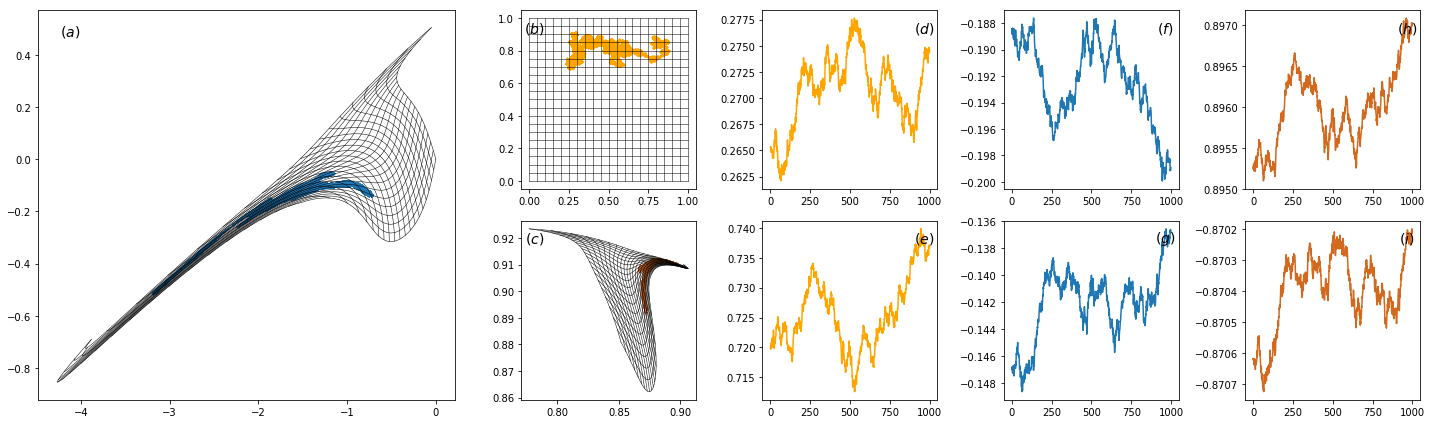

In [611]:
'''Plot Results for Mixing gbm'''
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 6)

N  = 200000
t0 = 10000
t1 = t0 + 1000

plt.figure(figsize=(20,6))
ax = plt.subplot(gs[0:2, 0:2])
grid_f1 = NNmixA((lines+1)/2)
plt.axis("on")
for line in grid_f1:
    plt.plot(line[0], line[1], linewidth=0.5, color="k")
X_gbm_noscale = torch.from_numpy(NNmixA(S_gbm)).float()
plt.scatter(X_gbm_noscale[:N,0], X_gbm_noscale[:N,1], s=0.1,rasterized=True)
plt.text(0.075, 0.945,'$(a)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
  
ax = plt.subplot(gs[0:1,2:3])
g0_lines = (lines+1)/2
plt.axis("on")
for line in g0_lines:
    t = torch.from_numpy(line.T)
    t = t.float().T
    t = t.detach().numpy()       # detach torch-tensor t from its 'gradient', as only then a numpy-conversion is possible 
    plt.plot(t[0], t[1], linewidth=0.5, color="k")
plt.scatter(S_gbm[:N,0], S_gbm[:N,1],s=0.1,c='orange', rasterized=True)
plt.text(0.075, 0.9,'$(b)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
ax = plt.subplot(gs[1:2,2:3])
g0_lines = sigic.rescale(torch.from_numpy(NNmixA((lines+1)/2)))
g0_lines = g0_lines.numpy()
plt.axis("on")
for line in g0_lines:
    t = torch.from_numpy(line.T)
    t = g1(t.float()).T
    t = t.detach().numpy()       # detach torch-tensor t from its 'gradient', as only then a numpy-conversion is possible 
    plt.plot(-t[1], t[0], linewidth=0.5, color="k")
plt.scatter(-Y_gbm[:N,1],Y_gbm[:N,0],s=0.1,c='chocolate',rasterized=True)
plt.text(0.075, 0.9,'$(c)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)

ax = plt.subplot(gs[0,3])
plt.plot(S_gbm[t0:t1,0], c='orange')
plt.text(0.925, 0.9,'$(d)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,3])
plt.plot(S_gbm[t0:t1,1], c='orange')
plt.text(0.925, 0.9,'$(e)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,4])
plt.plot(X_gbm[t0:t1,0])
plt.text(0.925, 0.9,'$(f)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,4])
plt.plot(X_gbm[t0:t1,1])
plt.text(0.925, 0.9,'$(g)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,5])
plt.plot(Y_gbm[t0:t1,0], c='chocolate')
plt.text(0.925, 0.9,'$(h)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,5])
plt.plot(Y_gbm[t0:t1,1], c='chocolate')
plt.text(0.925, 0.9,'$(i)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
plt.tight_layout()

#plt.savefig('NN_2D_ou.pdf', dpi=300)

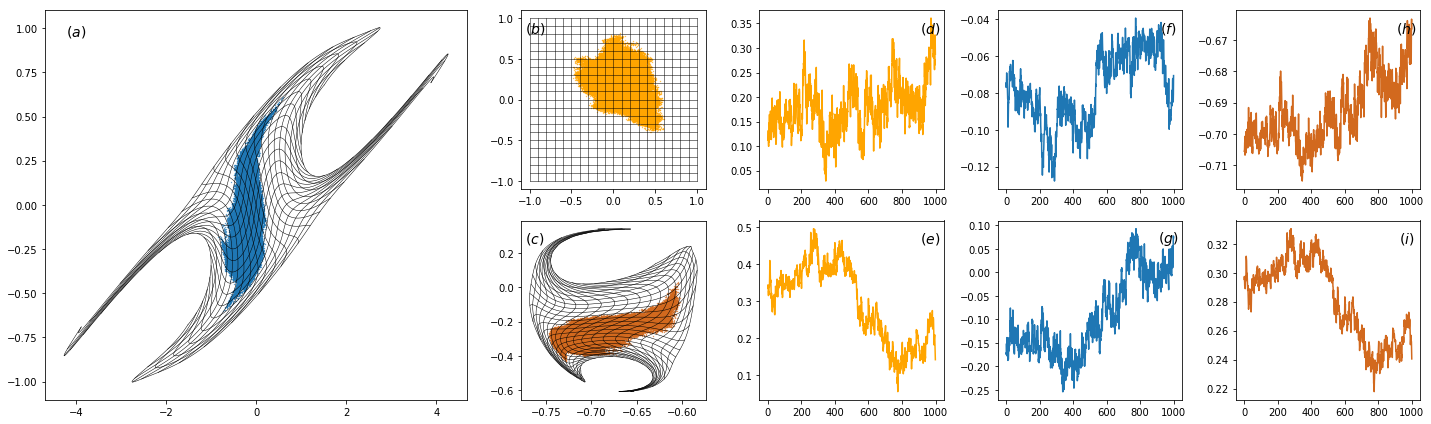

In [616]:
'''Plot Results for Mixing fbm'''
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 6)

N  = 200000
t0 = 10000
t1 = t0 + 1000

plt.figure(figsize=(20,6))
ax = plt.subplot(gs[0:2, 0:2])
grid_f1 = NNmixA(lines)
plt.axis("on")
for line in grid_f1:
    plt.plot(line[0], line[1], linewidth=0.5, color="k")
X_fbm_noscale = torch.from_numpy(NNmixA(S_fbm)).float()
plt.scatter(X_fbm_noscale[:N,0], X_fbm_noscale[:N,1], s=0.1,rasterized=True)
plt.text(0.075, 0.945,'$(a)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
  
ax = plt.subplot(gs[0:1,2:3])
g0_lines = lines
plt.axis("on")
for line in g0_lines:
    t = torch.from_numpy(line.T)
    t = t.float().T
    t = t.detach().numpy()       # detach torch-tensor t from its 'gradient', as only then a numpy-conversion is possible 
    plt.plot(t[0], t[1], linewidth=0.5, color="k")
plt.scatter(S_fbm[:N,0], S_fbm[:N,1],s=0.1,c='orange', rasterized=True)
plt.text(0.075, 0.9,'$(b)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
ax = plt.subplot(gs[1:2,2:3])
g0_lines = sigic.rescale(torch.from_numpy(NNmixA(lines)))
g0_lines = g0_lines.numpy()
plt.axis("on")
for line in g0_lines:
    t = torch.from_numpy(line.T)
    t = g2(t.float()).T
    t = t.detach().numpy()       # detach torch-tensor t from its 'gradient', as only then a numpy-conversion is possible 
    plt.plot(t[0], t[1], linewidth=0.5, color="k")
plt.scatter(Y_fbm[:N,0],Y_fbm[:N,1],s=0.1,c='chocolate',rasterized=True)
plt.text(0.075, 0.9,'$(c)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
ax = plt.subplot(gs[0,3])
plt.plot(S_fbm[t0:t1,0], c='orange')
plt.text(0.925, 0.9,'$(d)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,3])
plt.plot(S_fbm[t0:t1,1], c='orange')
plt.text(0.925, 0.9,'$(e)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,4])
plt.plot(X_fbm[t0:t1,0])
plt.text(0.925, 0.9,'$(f)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,4])
plt.plot(X_fbm[t0:t1,1])
plt.text(0.925, 0.9,'$(g)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,5])
plt.plot(Y_fbm[t0:t1,0], c='chocolate')
plt.text(0.925, 0.9,'$(h)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,5])
plt.plot(-Y_fbm[t0:t1,1], c='chocolate')
plt.text(0.925, 0.9,'$(i)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
plt.tight_layout()

#plt.savefig('NN_2D_cy.pdf', dpi=300)

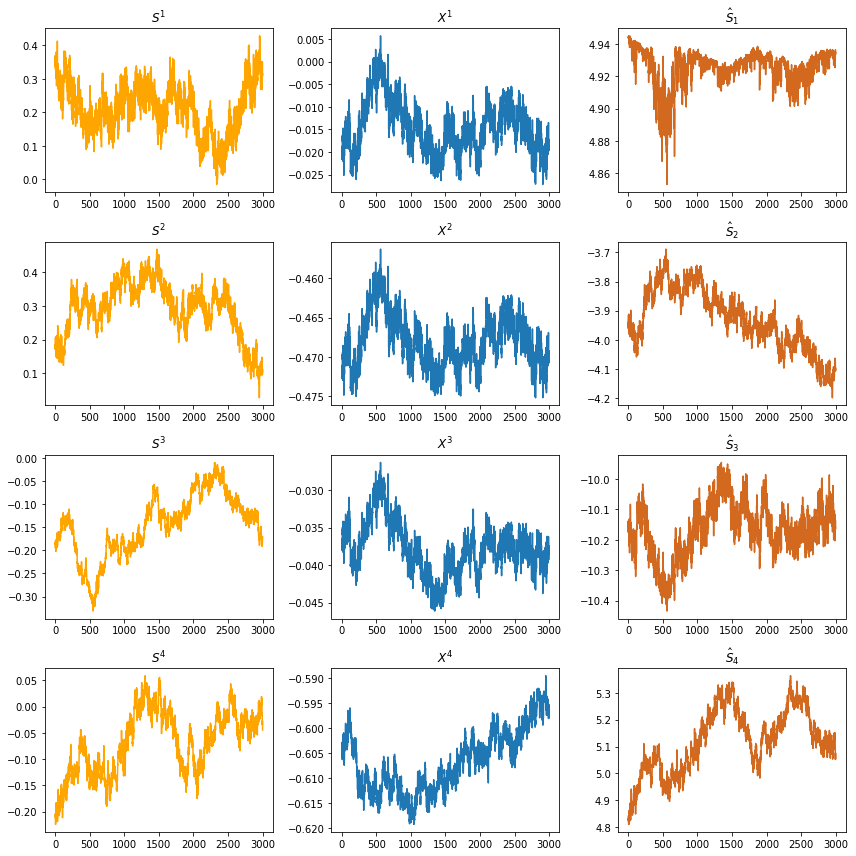

In [653]:
'''Plot Results for Mixing B'''
import matplotlib.gridspec as gridspec
gs    = gridspec.GridSpec(4, 3)

t0    = 90000
t1    = t0 + 3000

plt.figure(figsize=(12,12))
ax = plt.subplot(gs[0, 0])
plt.plot(S_4d[t0:t1,0], c='orange')
plt.title(r'$S^1$')

ax = plt.subplot(gs[1, 0])
plt.plot(S_4d[t0:t1,1], c='orange')
plt.title(r'$S^2$')

ax = plt.subplot(gs[2, 0])
plt.plot(S_4d[t0:t1,2], c='orange')
plt.title(r'$S^3$')

ax = plt.subplot(gs[3, 0])
plt.plot(S_4d[t0:t1,3], c='orange')
plt.title(r'$S^4$')
#######################################
ax = plt.subplot(gs[0, 1])
plt.plot(X_4d.detach()[t0:t1,0])
plt.title(r'$X^1$')

ax = plt.subplot(gs[1, 1])
plt.plot(X_4d.detach()[t0:t1,1])
plt.title(r'$X^2$') 

ax = plt.subplot(gs[2, 1])
plt.plot(X_4d.detach()[t0:t1,2])
plt.title(r'$X^3$') 

ax = plt.subplot(gs[3, 1])
plt.plot(X_4d.detach()[t0:t1,3])
plt.title(r'$X^4$') 
#######################################
ax = plt.subplot(gs[0, 2])
plt.plot(Y_4d[t0:t1,3], c='chocolate')
plt.title(r'$\hat{S}_1$')

ax = plt.subplot(gs[1, 2])
plt.plot(Y_4d[t0:t1,2], c='chocolate')
plt.title(r'$\hat{S}_2$')  

ax = plt.subplot(gs[2, 2])
plt.plot(Y_4d[t0:t1,0], c='chocolate')
plt.title(r'$\hat{S}_3$')   

ax = plt.subplot(gs[3, 2])
plt.plot(Y_4d[t0:t1,1], c='chocolate')
plt.title(r'$\hat{S}_4$')

plt.tight_layout()

#plt.savefig('NN_4D.pdf')

try to use linear ICA instead, and make comparison

use linear ICA for $R^2$ GBM

In [655]:
np.random.seed(0)
ica=FastICA(n_components=2, max_iter=500)
s_l_gbm=ica.fit_transform(X_gbm)
f_linear1=ica.mixing_

In [656]:
print("Monotone Concordance of S^ and S:\n",mondis.ConcordanceMatrix(s_l_gbm,S_gbm,100,1,'kendall'))

Monotone Concordance of S^ and S:
 [[0.20747296 0.58959043]
 [0.59746197 0.12769655]]


use linear ICA for $R^2$ FBM

In [657]:
np.random.seed(0)
ica=FastICA(n_components=2, max_iter=500)
s_l_fbm=ica.fit_transform(X_fbm)
f_linear2=ica.mixing_

In [658]:
print("Monotone Concordance of S^ and S:\n",mondis.ConcordanceMatrix(s_l_fbm,S_fbm,100,1,'kendall'))

Monotone Concordance of S^ and S:
 [[0.70078616 0.38634146]
 [0.26473719 0.56325793]]


In [662]:
np.random.seed(0)
ica=FastICA(n_components=4, max_iter=500)
s_l_fbm4d=ica.fit_transform(X_4d.detach().numpy())
f_linear4d=ica.mixing_

In [663]:
print("Monotone Concordance of S^ and S:\n",mondis.ConcordanceMatrix(s_l_fbm4d,S_4d,100,1,'kendall'))

Monotone Concordance of S^ and S:
 [[0.08693152 0.0284348  0.2137191  0.07424127]
 [0.07549953 0.39477134 0.00883099 0.29675788]
 [0.73858512 0.41522281 0.47032308 0.36392161]
 [0.03974141 0.39146716 0.38714796 0.44362059]]


Plot the results

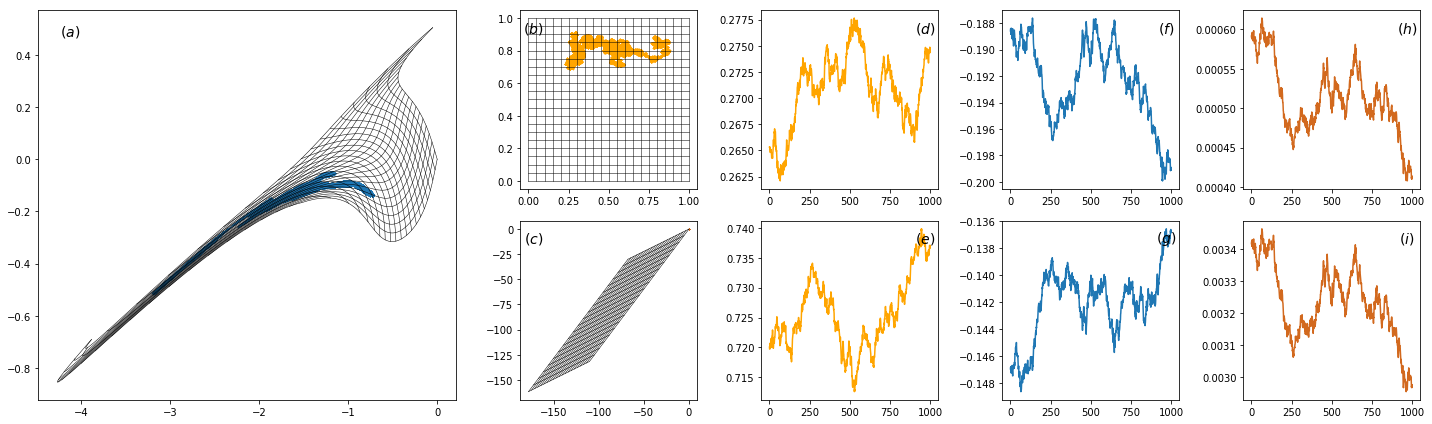

In [674]:
'''Plot Results for Mixing gbm based on FastICA'''
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 6)

N  = 200000
t0 = 10000
t1 = t0 + 1000

plt.figure(figsize=(20,6))
ax = plt.subplot(gs[0:2, 0:2])
grid_f1 = NNmixA((lines+1)/2)
plt.axis("on")
for line in grid_f1:
    plt.plot(line[0], line[1], linewidth=0.5, color="k")
X_gbm_noscale = torch.from_numpy(NNmixA(S_gbm)).float()
plt.scatter(X_gbm_noscale[:N,0], X_gbm_noscale[:N,1], s=0.1,rasterized=True)
plt.text(0.075, 0.945,'$(a)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
  
ax = plt.subplot(gs[0:1,2:3])
g0_lines = (lines+1)/2
plt.axis("on")
for line in g0_lines:
    t = torch.from_numpy(line.T)
    t = t.float().T
    t = t.detach().numpy()       # detach torch-tensor t from its 'gradient', as only then a numpy-conversion is possible 
    plt.plot(t[0], t[1], linewidth=0.5, color="k")
plt.scatter(S_gbm[:N,0], S_gbm[:N,1],s=0.1,c='orange', rasterized=True)
plt.text(0.075, 0.9,'$(b)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
ax = plt.subplot(gs[1:2,2:3])
grid_f1_l = f_linear1@((lines+1)/2)
plt.axis("on")
for line in grid_f1_l:
    plt.plot(line[0], line[1], linewidth=0.5, color="k")
plt.scatter(s_l_gbm[:N,1],s_l_gbm[:N,0],s=0.1,c='chocolate',rasterized=True)
plt.text(0.075, 0.9,'$(c)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)

ax = plt.subplot(gs[0,3])
plt.plot(S_gbm[t0:t1,0], c='orange')
plt.text(0.925, 0.9,'$(d)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,3])
plt.plot(S_gbm[t0:t1,1], c='orange')
plt.text(0.925, 0.9,'$(e)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,4])
plt.plot(X_gbm[t0:t1,0])
plt.text(0.925, 0.9,'$(f)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,4])
plt.plot(X_gbm[t0:t1,1])
plt.text(0.925, 0.9,'$(g)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,5])
plt.plot(s_l_gbm[t0:t1,0], c='chocolate')
plt.text(0.925, 0.9,'$(h)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,5])
plt.plot(-s_l_gbm[t0:t1,1], c='chocolate')
plt.text(0.925, 0.9,'$(i)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
plt.tight_layout()

#plt.savefig('NN_2D_ou.pdf', dpi=300)

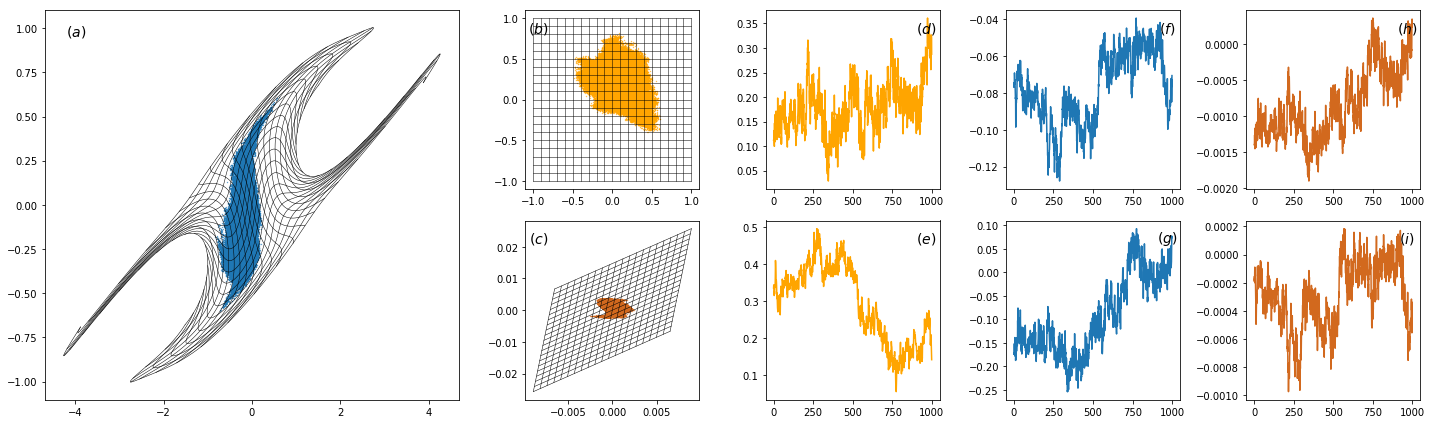

In [672]:
'''Plot Results for Mixing fbm based on FastICA'''
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 6)

N  = 200000
t0 = 10000
t1 = t0 + 1000

plt.figure(figsize=(20,6))
ax = plt.subplot(gs[0:2, 0:2])
grid_f1 = NNmixA(lines)
plt.axis("on")
for line in grid_f1:
    plt.plot(line[0], line[1], linewidth=0.5, color="k")
X_fbm_noscale = torch.from_numpy(NNmixA(S_fbm)).float()
plt.scatter(X_fbm_noscale[:N,0], X_fbm_noscale[:N,1], s=0.1,rasterized=True)
plt.text(0.075, 0.945,'$(a)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
  
ax = plt.subplot(gs[0:1,2:3])
g0_lines = lines
plt.axis("on")
for line in g0_lines:
    t = torch.from_numpy(line.T)
    t = t.float().T
    t = t.detach().numpy()       # detach torch-tensor t from its 'gradient', as only then a numpy-conversion is possible 
    plt.plot(t[0], t[1], linewidth=0.5, color="k")
plt.scatter(S_fbm[:N,0], S_fbm[:N,1],s=0.1,c='orange', rasterized=True)
plt.text(0.075, 0.9,'$(b)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
ax = plt.subplot(gs[1:2,2:3])
grid_f1_l = f_linear2@lines/10000
plt.axis("on")
for line in grid_f1_l:
    plt.plot(line[0], line[1], linewidth=0.5, color="k")
plt.scatter(s_l_fbm[:N,1],s_l_fbm[:N,0],s=0.1,c='chocolate',rasterized=True)
plt.text(0.075, 0.9,'$(c)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)

ax = plt.subplot(gs[0,3])
plt.plot(S_fbm[t0:t1,0], c='orange')
plt.text(0.925, 0.9,'$(d)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,3])
plt.plot(S_fbm[t0:t1,1], c='orange')
plt.text(0.925, 0.9,'$(e)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,4])
plt.plot(X_fbm[t0:t1,0])
plt.text(0.925, 0.9,'$(f)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,4])
plt.plot(X_fbm[t0:t1,1])
plt.text(0.925, 0.9,'$(g)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[0,5])
plt.plot(-s_l_fbm[t0:t1,0], c='chocolate')
plt.text(0.925, 0.9,'$(h)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax = plt.subplot(gs[1,5])
plt.plot(-s_l_fbm[t0:t1,1], c='chocolate')
plt.text(0.925, 0.9,'$(i)$', fontsize=14, ha='center', va='center', transform=ax.transAxes)
    
plt.tight_layout()

#plt.savefig('NN_2D_ou.pdf', dpi=300)